#  Objectif :
>
> 1. Construire une matrice BoW (Bag-of-Words) pour un corpus de 37 textes.
> 2. Calculer la matrice des distances entre tous les textes.
> 3. Calculer, pour chaque texte, la distance au **centroïde** (moyenne) de chaque **genre** (ex. *Aventure*, *Récit de voyage*, *Amour*).
> 4. **Bonus** : visualiser les distances (heatmap, MDS/TSNE).
>## 📦 Pré-requis

* Python ≥ 3.9
* `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `unidecode` (facultatif)
* Arborescence (adapter `CORPUS_DIR` si besoin) :

```
~/Documents/cours/2025/TALL_CPES_25-26/seance_04/TD/corpus/*.txt



```



## 🗂️ 0. Imports & paramètres


In [2]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.0 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 11.7 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 17.0 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [23]:
import os, re, json, textwrap
from pathlib import Path
from glob import glob



import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt

# (Optionnel) pour normaliser les accents dans les tokens
try:
    from unidecode import unidecode
    USE_UNIDECODE = True
except Exception:
    USE_UNIDECODE = False

In [20]:

path_txt = "corpus/*.txt"

# --- Paramètres BoW
MAX_FEATURES = 1000     # nb max de mots (les plus fréquents)
MIN_DF = 5              # mot conservé s'il apparaît dans >= MIN_DF documents

## 1. Charger les textes

> On lit tous les `.txt` du dossier, en gérant au mieux l’encodage.


In [59]:
corpus = []
doc_name = []
for doc in glob(path_txt):
    print(doc)
    doc_name.append(doc)
    with open(doc, encoding="utf8") as file_in:
        text = file_in.read()
        corpus.append(text.replace('\xa0', ' '))

corpus/1902_Loti-Pierre_Les-derniers-jours-de-Pekin.txt
corpus/1906_Gide-Andre_Amyntas.txt
corpus/1933_Veuzit-Max-du_Vers-l'unique.txt
corpus/1938_Larbaud-Valery_Aux-couleurs-de-Rome.txt
corpus/1905_Farrere-Claude_Les-civilises.txt
corpus/1955_Delly_Ourida.txt
corpus/1904_Le-Rouge-Gustave_L-Esclave-amoureuse.txt
corpus/1913_Delly_Entre-deux-ames.txt
corpus/1912_Loti-Pierre_Un-pelerin-d-Angkor 2.txt
corpus/1908_Veuzit-Max-du_Le-mystere-de-Malbackt.txt
corpus/2008_Rolin-Olivier_La-Chambre-des-cartes.txt
corpus/1913_Delly_Dans-l'ombre-du-mystere.txt
corpus/1913_Dombre-Roger_Un-tuteur-embarrasse.txt
corpus/1903_Vogue-Eugene-Melchior-de_Le-Maitre-de-la-mer.txt
corpus/1902_Le-Rouge-Gustave_La-Princesse-des-airs_Tome-II.txt
corpus/1905_Lermina-Jules_To-Ho-Le-Tueur-d-or.txt
corpus/1905_Le-Rouge-Gustave_L-Espionne-du-grand-Lama.txt
corpus/1912_Loti-Pierre_Un-pelerin-d-Angkor.txt
corpus/1932_Veuzit-Max-du_Petite-comtesse.txt
corpus/1900_Verne-Jules-_Seconde-patrie.txt
corpus/1905_Verne-Jules_Le-

In [49]:
len(corpus[0].split(' '))

70407

## 2. Genre mapping (à adapter)

In [10]:
import json

with open("genre_labels.json") as f:
    data = json.load(f)

In [14]:
data["texts"]

[{'title': '1900_Verne-Jules-_Seconde-patrie.txt', 'genre': 'aventures'},
 {'title': '1901_Thurner-Georges_Mademoiselle-Flammette.txt',
  'genre': 'sentimental'},
 {'title': '1902_Allais-Alphonse_Le-Captain-Cap.txt', 'genre': 'aventures'},
 {'title': '1902_Le-Rouge-Gustave_La-Princesse-des-airs_Tome-II.txt',
  'genre': 'aventures'},
 {'title': '1902_Le-Rouge-Gustave_La-Princesse-des-airs_Tome-I.txt',
  'genre': 'aventures'},
 {'title': '1902_Loti-Pierre_Les-derniers-jours-de-Pekin.txt',
  'genre': 'voyage'},
 {'title': '1903_Loti-Pierre_L-Inde-(sans-les-Anglais).txt',
  'genre': 'voyage'},
 {'title': '1903_Vogue-Eugene-Melchior-de_Le-Maitre-de-la-mer.txt',
  'genre': 'aventures'},
 {'title': '1904_Le-Rouge-Gustave_L-Esclave-amoureuse.txt',
  'genre': 'sentimental'},
 {'title': '1904_Loti-Pierre_Vers-Ispahan.txt', 'genre': 'voyage'},
 {'title': '1905_Farrere-Claude_Les-civilises.txt', 'genre': 'aventures'},
 {'title': '1905_Lermina-Jules_To-Ho-Le-Tueur-d-or.txt', 'genre': 'aventures'},



## 🧱 3. Fonctions utilitaires : distances & BoW

> Nous vous **donnons** ci-dessous :
>
> * des définitions simples des **distances** (Cosine & Euclidienne)
> * une fonction pour construire le **DataFrame BoW** : N lignes = N romans ; M colonnes = M mots.


In [63]:
from collections import Counter

In [54]:
def get_vocabulary(corpus, N=1000):
    texte_main = ""
    for texte in corpus:
        texte_main+=texte
    compteur = Counter(texte_main.split(" "))
    liste_1000 = compteur.most_common(N)
    return liste_1000

In [55]:
mots_a_compter = get_vocabulary(corpus)

In [56]:
mots_a_compter = [elem[0] for elem in mots_a_compter]

In [58]:
len(mots_a_compter)




1000

In [83]:
from tqdm import tqdm

In [84]:
def get_df_bow(liste_N_mots, corpus):
    liste_globale = []
    for txt in tqdm(corpus):
        liste_courante = []
        dico_courant = dict(Counter(txt.split(" ")))
        for mot in liste_N_mots:
            if mot in dico_courant:
                liste_courante.append(dico_courant[mot]/len(txt.split(" ")))
            else:
                liste_courante.append(0)
        liste_globale.append(liste_courante)

    return pd.DataFrame(liste_globale, columns=liste_N_mots)

In [85]:
df_BOW = get_df_bow(mots_a_compter, corpus)


100%|███████████████████████████████████████████| 37/37 [02:55<00:00,  4.74s/it]


In [75]:
df_BOW

,de,la,et,à,le,les,,des,que,en,...,encore.,lieutenant,reprendre,malade,professeur,Captain,"pourtant,",chaleur,toi,n’est-ce
0,0.056855,0.020069,0.025722,0.014658,0.014530,0.023350,0.014814,0.025722,0.007315,0.011561,...,0.000071,0.000028,0.000071,0.000014,0.000000,0.000000,0.000043,0.000085,0.000014,0.000014
1,0.035207,0.023904,0.017996,0.012908,0.019601,0.014513,0.024997,0.011610,0.011508,0.006625,...,0.000273,0.000000,0.000000,0.000034,0.000000,0.000000,0.000137,0.000410,0.000205,0.000034
2,0.037827,0.020923,0.015842,0.017812,0.015262,0.009911,0.000328,0.005641,0.015513,0.009718,...,0.000000,0.000000,0.000097,0.000039,0.000097,0.000000,0.000097,0.000039,0.000039,0.000193
3,0.046776,0.024053,0.033102,0.017758,0.016088,0.015727,0.011282,0.011553,0.012884,0.009364,...,0.000135,0.000000,0.000113,0.000068,0.000000,0.000000,0.000068,0.000045,0.000068,0.000000
4,0.038415,0.022402,0.030503,0.015260,0.018685,0.015911,0.028088,0.012811,0.008135,0.008272,...,0.000120,0.000034,0.000017,0.000120,0.000000,0.000000,0.000000,0.000103,0.000069,0.000000
5,0.044646,0.024304,0.015441,0.017744,0.016270,0.008439,0.000129,0.004772,0.011866,0.009305,...,0.000055,0.000000,0.000092,0.000387,0.000000,0.000000,0.000092,0.000000,0.000276,0.000147
6,0.055271,0.021665,0.027353,0.015895,0.015089,0.014645,0.032920,0.011861,0.007383,0.008593,...,0.000000,0.000000,0.000000,0.000403,0.000000,0.000000,0.000000,0.000040,0.000161,0.000000
7,0.048489,0.020954,0.018167,0.019594,0.014792,0.010057,0.000067,0.005356,0.012055,0.010813,...,0.000050,0.000000,0.000050,0.000034,0.000000,0.000000,0.000050,0.000050,0.000084,0.000134
8,0.049925,0.019511,0.022030,0.016504,0.015677,0.021541,0.011128,0.026015,0.010188,0.010752,...,0.000075,0.000000,0.000075,0.000038,0.000038,0.000000,0.000113,0.000489,0.000000,0.000000
9,0.042590,0.016410,0.019101,0.019368,0.016906,0.009102,0.000153,0.005076,0.016792,0.010342,...,0.000114,0.000000,0.000095,0.000515,0.000019,0.000000,0.000229,0.000038,0.000191,0.000057


In [80]:
df_BOW.set_index([doc_name], inplace=True)

In [81]:
df_BOW

,de,la,et,à,le,les,,des,que,en,...,encore.,lieutenant,reprendre,malade,professeur,Captain,"pourtant,",chaleur,toi,n’est-ce
corpus/1902_Loti-Pierre_Les-derniers-jours-de-Pekin.txt,0.056855,0.020069,0.025722,0.014658,0.014530,0.023350,0.014814,0.025722,0.007315,0.011561,...,0.000071,0.000028,0.000071,0.000014,0.000000,0.000000,0.000043,0.000085,0.000014,0.000014
corpus/1906_Gide-Andre_Amyntas.txt,0.035207,0.023904,0.017996,0.012908,0.019601,0.014513,0.024997,0.011610,0.011508,0.006625,...,0.000273,0.000000,0.000000,0.000034,0.000000,0.000000,0.000137,0.000410,0.000205,0.000034
corpus/1933_Veuzit-Max-du_Vers-l'unique.txt,0.037827,0.020923,0.015842,0.017812,0.015262,0.009911,0.000328,0.005641,0.015513,0.009718,...,0.000000,0.000000,0.000097,0.000039,0.000097,0.000000,0.000097,0.000039,0.000039,0.000193
corpus/1938_Larbaud-Valery_Aux-couleurs-de-Rome.txt,0.046776,0.024053,0.033102,0.017758,0.016088,0.015727,0.011282,0.011553,0.012884,0.009364,...,0.000135,0.000000,0.000113,0.000068,0.000000,0.000000,0.000068,0.000045,0.000068,0.000000
corpus/1905_Farrere-Claude_Les-civilises.txt,0.038415,0.022402,0.030503,0.015260,0.018685,0.015911,0.028088,0.012811,0.008135,0.008272,...,0.000120,0.000034,0.000017,0.000120,0.000000,0.000000,0.000000,0.000103,0.000069,0.000000
corpus/1955_Delly_Ourida.txt,0.044646,0.024304,0.015441,0.017744,0.016270,0.008439,0.000129,0.004772,0.011866,0.009305,...,0.000055,0.000000,0.000092,0.000387,0.000000,0.000000,0.000092,0.000000,0.000276,0.000147
corpus/1904_Le-Rouge-Gustave_L-Esclave-amoureuse.txt,0.055271,0.021665,0.027353,0.015895,0.015089,0.014645,0.032920,0.011861,0.007383,0.008593,...,0.000000,0.000000,0.000000,0.000403,0.000000,0.000000,0.000000,0.000040,0.000161,0.000000
corpus/1913_Delly_Entre-deux-ames.txt,0.048489,0.020954,0.018167,0.019594,0.014792,0.010057,0.000067,0.005356,0.012055,0.010813,...,0.000050,0.000000,0.000050,0.000034,0.000000,0.000000,0.000050,0.000050,0.000084,0.000134
corpus/1912_Loti-Pierre_Un-pelerin-d-Angkor 2.txt,0.049925,0.019511,0.022030,0.016504,0.015677,0.021541,0.011128,0.026015,0.010188,0.010752,...,0.000075,0.000000,0.000075,0.000038,0.000038,0.000000,0.000113,0.000489,0.000000,0.000000
corpus/1908_Veuzit-Max-du_Le-mystere-de-Malbackt.txt,0.042590,0.016410,0.019101,0.019368,0.016906,0.009102,0.000153,0.005076,0.016792,0.010342,...,0.000114,0.000000,0.000095,0.000515,0.000019,0.000000,0.000229,0.000038,0.000191,0.000057


## 📏 5. Matrice des distances entre textes

> Choisissez une métrique : **cosine** (recommandée pour du texte) ou **euclidienne** (sur BoW bruts).


In [61]:
# 5) Distance functions (exactement comme spécifié)

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def vector_len(v):
    return np.sqrt(np.sum(v ** 2))

def cosine_distance(a, b):
    return 1 - np.dot(a, b) / (vector_len(a) * vector_len(b))

In [143]:
DF_GENRES_DISTANCES

,voyages,aventures,sentimental,genres
1900_Verne-Jules-_Seconde-patrie.txt,0.054669,0.021006,0.087088,aventures
1901_Thurner-Georges_Mademoiselle-Flammette.txt,0.112905,0.054822,0.030193,sentimental
1902_Allais-Alphonse_Le-Captain-Cap.txt,0.060211,0.036255,0.071234,aventures
1902_Le-Rouge-Gustave_La-Princesse-des-airs_Tome-I.txt,0.051275,0.013558,0.075158,aventures
1902_Le-Rouge-Gustave_La-Princesse-des-airs_Tome-II.txt,0.042219,0.009491,0.078938,aventures
1902_Loti-Pierre_Les-derniers-jours-de-Pekin.txt,0.023148,0.087998,0.187315,voyages
1903_Loti-Pierre_L-Inde-(sans-les-Anglais).txt,0.021663,0.087024,0.182324,voyages
1903_Vogue-Eugene-Melchior-de_Le-Maitre-de-la-mer.txt,0.074642,0.034316,0.054726,aventures
1904_Le-Rouge-Gustave_L-Esclave-amoureuse.txt,0.065520,0.029844,0.067647,aventures
1904_Loti-Pierre_Vers-Ispahan.txt,0.028433,0.097261,0.195289,voyages


## 📊 7. Bonus — Visualisations


# 7.2) Heatmap (matplotlib)
plt.figure(figsize=(8, 7))
plt.imshow(df_D_cos, interpolation="nearest")




In [130]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


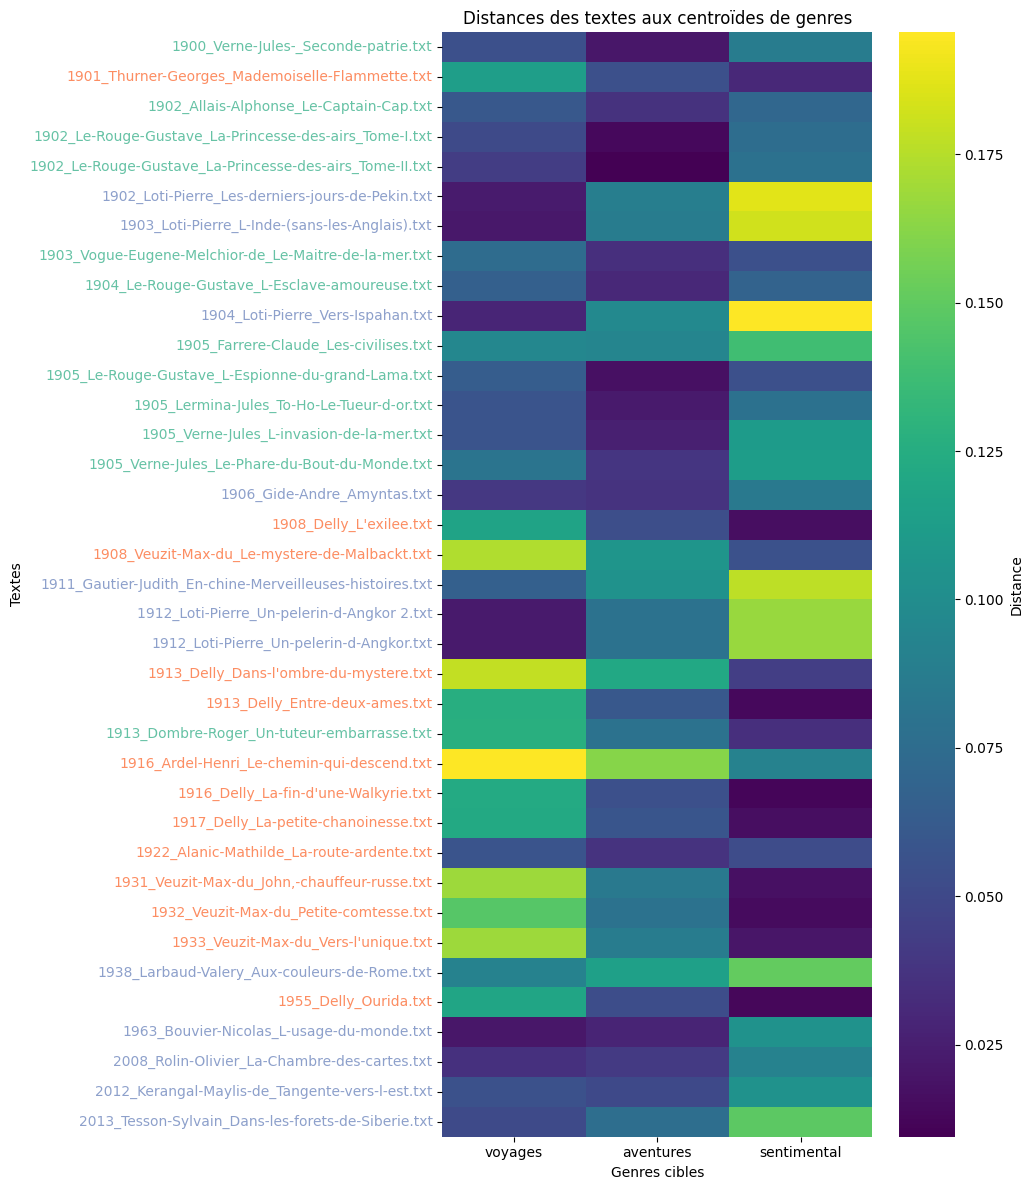

In [148]:
plot_genre_distance_heatmap(DF_GENRES_DISTANCES)